In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [3]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     LSTM_stop_final_lstm_ablation.ipynb
 Balanced_II_hotel_dataset_final.ipynb    optuna_test/
 booking_time_final_original/             output/
 Business_hotel_dataset_final.ipynb       output_other_dataset/
 clustered_test.pkl                       Preprocess_data_dunnhumby.ipynb
 copy_optuna_test/                        Preprocess_data_full_hotel_dataset_final.ipynb
 data_analysis/                           price_tft/
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final_dunnhumby.ipynb
 lightning_logs/                          RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_enc

Imported libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import plotly.express as px

In [5]:
df_transaction_data = pd.read_csv("output_other_dataset/transaction_data.csv")

In [6]:
df_groupby = df_transaction_data.copy()
df_groupby = df_groupby.drop(["PRODUCT_ID", "STORE_ID", "DAY"], axis = 1)
df_groupby = df_groupby.set_index(["household_key", "BASKET_ID"]).groupby("household_key").agg({"QUANTITY" : "size", "SALES_VALUE" : "mean", "RETAIL_DISC" : "mean", "TRANS_TIME" : "mean", "WEEK_NO" : "mean", "COUPON_DISC" : "mean", "COUPON_MATCH_DISC" : "mean"})

**The clusters look to similar so it is decided to not do clusters in this case**


In [7]:
X = df_groupby
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
kmeans = KMeans(
        n_clusters= 3, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
kmeans.fit(X)
# X_inverse = scaler.inverse_transform(X)
# clusters=pd.DataFrame(X_inverse,columns=df_all_hotels.drop("guest_id",axis=1).columns)
clusters=pd.DataFrame(X,columns=df_groupby.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig4.show()

In [8]:
df_copy = df_transaction_data.copy()
df_copy = df_copy.groupby(["household_key", "BASKET_ID"]).agg({"QUANTITY" : "size", "SALES_VALUE" : "size", "RETAIL_DISC" : "mean", "TRANS_TIME" : "mean", "WEEK_NO" : "mean", "COUPON_DISC" : "mean", "COUPON_MATCH_DISC" : "mean"})

In [9]:
df_day = df_transaction_data.groupby(["household_key", "BASKET_ID"])["DAY"].agg(pd.Series.mode).to_frame()

In [10]:
new_df = pd.merge(df_copy, df_day, on = ["household_key", "BASKET_ID"])

In [11]:
new_df = new_df.reset_index()
new_df["days_between"] = -1000
for i in range(len(new_df)-1):
  if new_df["household_key"][i] == new_df["household_key"][i+1]:
    new_df["days_between"][i] = new_df["DAY"][i+1] - new_df["DAY"][i]
  else:
    new_df["days_between"][i] = -1000

<ipython-input-11-a60a2792504d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-a60a2792504d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
new_df = new_df.loc[(new_df["days_between"] == -1000) | (new_df["days_between"] > 0)]

In [13]:

list_index = []
# df_hotel_sorted_0 = df_all_hotels_0.set_index(["guest_id"]).sort_index()
for house in new_df["household_key"].unique():
  num_times_house = len(new_df[new_df["household_key"] == house])
  t_index_column = list(range(1, num_times_house + 1))
  list_index.append(t_index_column)
list_index_new = [item for sublist in list_index for item in sublist]
new_df["time_index"] = list_index_new

In [14]:
new_df = new_df.reset_index()

In [15]:
new_df = new_df.set_index(["household_key", "BASKET_ID"])

In [16]:
X = new_df.drop(["days_between", "WEEK_NO", "TRANS_TIME", "time_index", "index"], axis = 1)
y = new_df["days_between"]

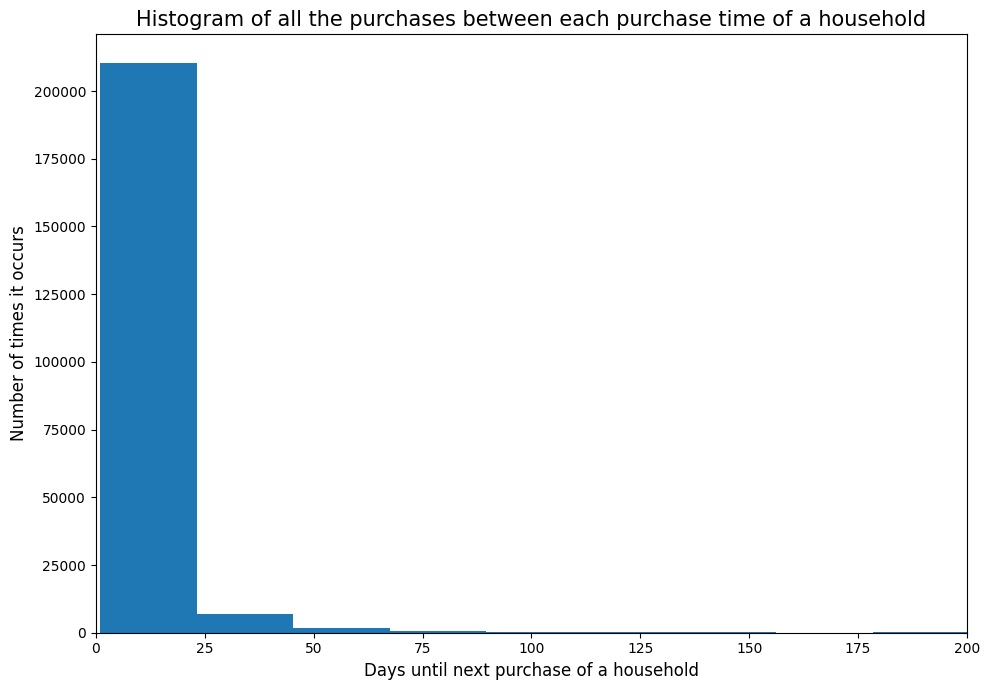

In [17]:
y_without_1000 = y[y > 0]
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(y_without_1000, bins = 30)
plt.title("Histogram of all the purchases between each purchase time of a household", size = 15)
plt.xlabel("Days until next purchase of a household", size = 12)
plt.ylabel("Number of times it occurs", size = 12)
plt.xlim(0,200)
# Show plot
plt.show()

In [ ]:
y.to_csv('output_other_dataset/y_original_data')

TODO: Use different scalers to show the differences in predictions

In [ ]:
scaler = RobustScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output_other_dataset/df_original_data_robustscaler')

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output_other_dataset/df_original_data')

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output_other_dataset/df_original_data_standardscaler')

In [ ]:
X.describe()

,QUANTITY,SALES_VALUE,RETAIL_DISC,COUPON_DISC,COUPON_MATCH_DISC,DAY
count,223331.000000,223331.000000,2.233310e+05,223331.000000,223331.000000,223331.000000
mean,9.912318,9.912318,-5.735880e-01,-0.013575,-0.001571,385.790378
std,12.507079,12.507079,1.110067e+00,0.128537,0.016912,189.368927
min,1.000000,1.000000,-9.005000e+01,-15.000000,-3.500000,1.000000
25%,2.000000,2.000000,-7.072850e-01,0.000000,0.000000,224.000000
50%,5.000000,5.000000,-3.810000e-01,0.000000,0.000000,389.000000
75%,13.000000,13.000000,-1.357143e-01,0.000000,0.000000,549.000000
max,168.000000,168.000000,1.110223e-16,0.000000,0.000000,711.000000
